<a href="https://colab.research.google.com/github/matteo4diani/federated-survival-analysis/blob/main/federated_survival_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install memory_profiler
!pip install seaborn
!pip install torch
!pip install tensorboard
!pip install flower
!pip install scikit-learn
!pip install scikit-survival
!pip install --upgrade ipython


# Clone PyTorch/StableBaselines wrappers
!git clone https://github.com/matteo4diani/federated-survival-analysis-utils.git
     

# Put the downloaded repo on path so we can import custom libraries into Colab
import sys
sys.path.insert(0,'/content/federated-survival-analysis-utils')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 775.8/775.8 KB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.4/386.4 KB 37.6 MB/s eta 0:00:00
  Attempting uninstall: prompt-toolkit
    Found existing installa

In [9]:
from sksurv.datasets import load_veterans_lung_cancer
import seaborn as sns
import numpy as np
import pandas as pd


[( True,  72.) ( True, 411.) ( True, 228.) ( True, 126.) ( True, 118.)
 ( True,  10.) ( True,  82.) ( True, 110.) ( True, 314.) (False, 100.)
 ( True,  42.) ( True,   8.) ( True, 144.) (False,  25.) ( True,  11.)
 ( True,  30.) ( True, 384.) ( True,   4.) ( True,  54.) ( True,  13.)
 (False, 123.) (False,  97.) ( True, 153.) ( True,  59.) ( True, 117.)
 ( True,  16.) ( True, 151.) ( True,  22.) ( True,  56.) ( True,  21.)
 ( True,  18.) ( True, 139.) ( True,  20.) ( True,  31.) ( True,  52.)
 ( True, 287.) ( True,  18.) ( True,  51.) ( True, 122.) ( True,  27.)
 ( True,  54.) ( True,   7.) ( True,  63.) ( True, 392.) ( True,  10.)
 ( True,   8.) ( True,  92.) ( True,  35.) ( True, 117.) ( True, 132.)
 ( True,  12.) ( True, 162.) ( True,   3.) ( True,  95.) ( True, 177.)
 ( True, 162.) ( True, 216.) ( True, 553.) ( True, 278.) ( True,  12.)
 ( True, 260.) ( True, 200.) ( True, 156.) (False, 182.) ( True, 143.)
 ( True, 105.) ( True, 103.) ( True, 250.) ( True, 100.) ( True, 999.)
 ( Tru

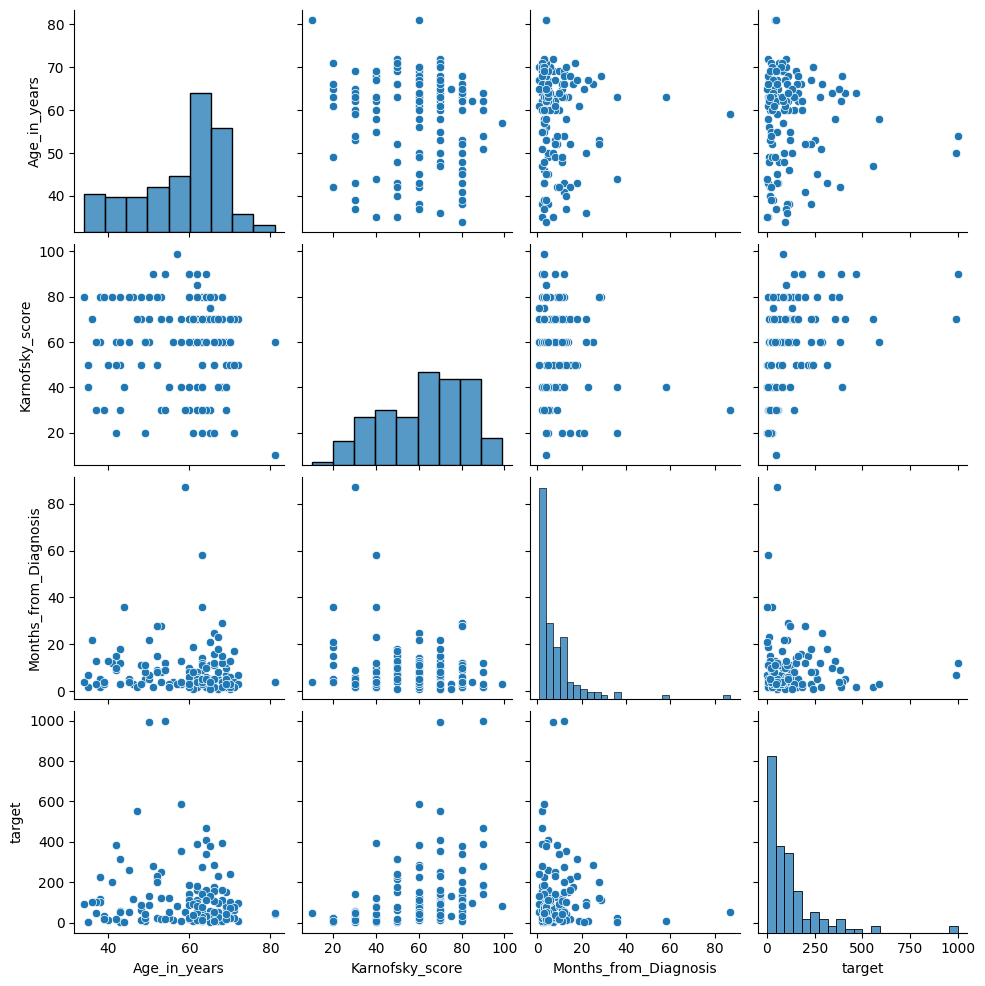

In [24]:
data_x, data_y = load_veterans_lung_cancer()

print(data_y)
print(data_x)

print(data_x.shape)
print(data_x.shape)

data_y_dict = {'target': pd.Series(map(lambda y: y[1], data_y))}

data_df = pd.DataFrame({**data_x.to_dict(),
              **data_y_dict})
              
sns.pairplot(data_df)